In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from IPython.display import display
from sklearn import naive_bayes, linear_model, tree, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from collections import OrderedDict

In [4]:
def load_reviews(path, fold_nrs, label):
    columns = ['Raw', 'Processed', 'Label']
    df = pd.DataFrame()
    for i in fold_nrs:
        fold = "fold"+str(i)
        p = path + fold
        for file in os.listdir(p): # for each .txt file in this fold's folder
            if file.endswith(".txt"):
                f = open(os.path.join(p, file), "r")
                review = f.read()
                # remove whitespaces, numbers, punctuation, & make lowercase
                processed = process_string(review)
                new_row = pd.DataFrame([[review, processed, label]])
                df = df.append(new_row)
    df.columns = columns
    return df

def make_train_test_set():
    # Focusing only on the negative reviews
    path_dec = "./op_spam_v1.4/negative_polarity/deceptive_from_MTurk/"
    path_true = "./op_spam_v1.4/negative_polarity/truthful_from_Web/"

    # Label = 1 if it is a truthful (negative) review, =0 if it is a deceptive (negative) review

    #loading training set:
    train_dec = load_reviews(path_dec, np.arange(4)+1, 0) # folds 1-4 form the training set
    train_true = load_reviews(path_true, np.arange(4)+1, 1)
    train = pd.concat([train_dec, train_true])
    train = train.reset_index(drop=True)

    #loading the test set:
    test_dec = load_reviews(path_dec, [5], 0)  # test set for deceptive reviews
    test_true = load_reviews(path_true, [5], 1)
    test = pd.concat([test_dec, test_true])
    test = test.reset_index(drop=True)

    return [train,test]

def process_string(s):
    s = s.strip()    # remove whitespaces
    s = s.lower() # to lowercase
    s = re.sub(r'\d+', '', s) # remove numbers
    s = s.translate(str.maketrans("","", string.punctuation)) # remove punctuation
    return s


##########################
###Process files to CSV###
##########################

train, test = make_train_test_set()
train.to_csv("./train.csv", header = ['Raw', 'Processed', 'Label'], index=False)
test.to_csv("./test.csv", header = ['Raw', 'Processed', 'Label'], index=False)


In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("test.csv")

print(f"\n Shape of training set: {train.shape}")
print(train.head())
print(f"\n Shape of test set: {test.shape}")
print(test.head())

train.head()


 Shape of training set: (640, 3)
                                                 Raw  ... Label
0  We stayed at the Schicago Hilton for 4 days an...  ...     0
1  Hotel is located 1/2 mile from the train stati...  ...     0
2  I made my reservation at the Hilton Chicago be...  ...     0
3  When most people think Hilton, they think luxu...  ...     0
4  My husband and I recently stayed stayed at the...  ...     0

[5 rows x 3 columns]

 Shape of test set: (160, 3)
                                                 Raw  ... Label
0  I recently stayed at the Hotel Allegro Chicago...  ...     0
1  I recently stayed at the Hotel Allegro in Chic...  ...     0
2  I recently visited Chicago. I stayed at the Ho...  ...     0
3  I visited the Hotel Allegro Chicago while I wa...  ...     0
4  I was unimpressed by the quality of this hotel...  ...     0

[5 rows x 3 columns]


,Raw,Processed,Label
0,We stayed at the Schicago Hilton for 4 days an...,we stayed at the schicago hilton for days and...,0
1,Hotel is located 1/2 mile from the train stati...,hotel is located mile from the train station ...,0
2,I made my reservation at the Hilton Chicago be...,i made my reservation at the hilton chicago be...,0
3,"When most people think Hilton, they think luxu...",when most people think hilton they think luxur...,0
4,My husband and I recently stayed stayed at the...,my husband and i recently stayed stayed at the...,0


In [6]:
def make_xy_train_test(train, test, bigram = False, min_df = False):
    stpw = stopwords.words('english')

    if bigram: # use training data to make vectorizer (vocabulary)
        vectorizer = TfidfVectorizer(stop_words = stpw, ngram_range=(1,2),min_df = min_df)
    else:
        vectorizer = TfidfVectorizer(stop_words = stpw,min_df = min_df)
    print(f'Words must appear at least in {min_df*100}% of the reviews to become feature')
    vec = vectorizer.fit_transform(train["Processed"])
    features = pd.DataFrame(vec.toarray(),columns=vectorizer.get_feature_names())
    
    test_vec = vectorizer.transform(test["Processed"])
    test_features = pd.DataFrame(test_vec.toarray(),columns=vectorizer.get_feature_names())

    train_merged = pd.merge(train, features, left_index = True, right_index = True).sample(frac=1) #merge data and shuffle
    test_merged = pd.merge(test, test_features, left_index = True, right_index = True).sample(frac=1) #merge data and shuffle
    
    print(f'The model contains {features.shape[1]} features')

    # print("features shape", features.shape)
    # print("test features shape", test_features.shape)
    # print("test shape", test.shape)
    # print("test merged", test_merged.shape)
    return [train_merged.iloc[:,3:], train_merged["Label"], test_merged.iloc[:,3:], test_merged["Label"]] #return [x_train, y_train,

def make_countvec_xy_train_test(train, test, bigram = False, binary = False,min_df = False):
    stpw = stopwords.words('english')

    if bigram: # use training data to make vectorizer (vocabulary)
        vectorizer = CountVectorizer(stop_words = stpw, binary=binary, ngram_range=(1,2), min_df = min_df)
    else:
        vectorizer = CountVectorizer(stop_words = stpw, binary = binary, min_df = min_df)
    print(f'Words must appear at least in {min_df*100}% of the reviews to become feature')

    vec = vectorizer.fit_transform(train["Processed"])
    features = pd.DataFrame(vec.toarray(),columns=vectorizer.get_feature_names())
    
    test_vec = vectorizer.transform(test["Processed"])
    test_features = pd.DataFrame(test_vec.toarray(),columns=vectorizer.get_feature_names())

    train_merged = pd.merge(train, features, left_index = True, right_index = True).sample(frac=1) #merge data and shuffle
    test_merged = pd.merge(test, test_features, left_index = True, right_index = True).sample(frac=1) #merge data and shuffle
        
    print(f'The model contains {features.shape[1]} features')
        
    # print("features shape", features.shape)
    # print("test features shape", test_features.shape)
    # print("test shape", test.shape)
    # print("test merged", test_merged.shape)
    return [train_merged.iloc[:,3:], train_merged["Label"], test_merged.iloc[:,3:], test_merged["Label"]] #return [x_train, y_train, x_test,y_test]

train_x, train_y, test_x, test_y = make_xy_train_test(train, test, min_df=0.01)
#train_x, train_y, test_x, test_y = make_countvec_xy_train_test(train, test)

#train_x, train_y = make_xy(train)
#test_x, test_y = make_xy(test)

bitrain_x, bitrain_y, bitest_x, bitest_y = make_xy_train_test(train, test, bigram=True,min_df=0.05)
#bitrain_x, bitrain_y, bitest_x, bitest_y = make_countvec_xy_train_test(train, test, bigram=True)

#bitrain_x, bitrain_y = make_xy(train, bigram = True)
#bitest_x, bitest_y = make_xy(test, bigram = True)


display(train_x.head())
display(train_y.head())
display(test_x.head())
display(test_y.head())

display(bitrain_x.head())
display(bitrain_y.head())
display(bitest_x.head())
display(bitest_y.head())

Words must appear at least in 1.0% of the reviews to become feature
The model contains 1255 features
Words must appear at least in 5.0% of the reviews to become feature
The model contains 337 features


,able,absolutely,ac,access,accommodate,accommodations,account,across,acted,actual,actually,add,addition,additional,additionally,adequate,adjacent,advance,advertised,affinia,afternoon,agent,ago,agreed,ahead,air,airport,allow,allowed,almost,along,already,alright,also,although,always,amazing,ambassador,amenities,american,...,wet,weve,whatever,white,whole,wife,wifi,window,windows,wine,wireless,wish,within,without,woke,woman,wonderful,wont,word,words,work,worked,working,world,worn,worse,worst,worth,would,wouldnt,write,wrong,year,years,yelling,yes,yet,youd,young,youre
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.120041,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.070866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.215855,0.0,0.0,0.0,0.211868,0.0,0.0,0.0,0.0,0.213975,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.146894,0.000000,0.073727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.117371,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.054449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.162196,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.123006,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.113885,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153605,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.129002,0.0,0.0,0.0,0.134861,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149253,0.0,0.0,0.0


15     0
200    0
143    0
11     0
418    1
Name: Label, dtype: int64

,able,absolutely,ac,access,accommodate,accommodations,account,across,acted,actual,actually,add,addition,additional,additionally,adequate,adjacent,advance,advertised,affinia,afternoon,agent,ago,agreed,ahead,air,airport,allow,allowed,almost,along,already,alright,also,although,always,amazing,ambassador,amenities,american,...,wet,weve,whatever,white,whole,wife,wifi,window,windows,wine,wireless,wish,within,without,woke,woman,wonderful,wont,word,words,work,worked,working,world,worn,worse,worst,worth,would,wouldnt,write,wrong,year,years,yelling,yes,yet,youd,young,youre
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.171248,0.0,0.056853,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.110653,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.078059,0.0,0.039178,0.000000,0.0,0.000000,0.0,0.094338,0.0,0.102911,0.0,0.000000,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.162009,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.139934,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055821,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.160413,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.214273,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214273,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.08419,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.049701,0.107869,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.295462,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086601,0.0,0.0,0.064481,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.063284,0.000000,0.0,0.067311,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


33     0
102    1
54     0
135    1
69     0
Name: Label, dtype: int64

,able,actually,air,almost,already,also,although,amenities,another,anyone,anything,area,around,arrived,ask,asked,available,away,back,bad,bar,bathroom,bed,beds,best,better,big,bit,booked,breakfast,broken,business,call,called,called front,came,cant,car,card,carpet,...,tried,trip,try,tv,two,unfortunately,upon,us,use,used,view,visit,wait,waiting,walk,wall,walls,want,wanted,wasnt,water,way,website,week,weekend,well,went,whole,wife,wifi,without,wont,work,working,worst,worth,would,would recommend,wouldnt,wrong
513,0.0,0.152902,0.0,0.0,0.0,0.000000,0.0,0.159847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.215214,0.000000,0.0,0.153827,0.0,0.000000,0.152902,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.154772,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.12420,0.0,0.0,0.0,0.0,0.118583,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.222461,0.0,0.000000,0.000000
554,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.293517,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.291485,0.000000
376,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.339694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.286129,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.26394,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.157585,0.0,0.000000,0.000000
429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150734,0.000000,0.0,0.000000,0.000000,0.183538,0.000000,0.133615,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207911,...,0.000000,0.0,0.0,0.0,0.148398,0.000000,0.0,0.0,0.0,0.0,0.000000,0.216514,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
268,0.0,0.000000,0.0,0.0,0.0,0.105994,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.271298,0.0,0.100002,0.122338,0.136282,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.138914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.158527,0.0,0.0,0.0,0.110190,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.271298,0.0,0.120556,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.160768,0.0,0.0,0.0,0.0,0.073042,0.0,0.000000,0.155378


513    1
554    1
376    1
429    1
268    0
Name: Label, dtype: int64

,able,actually,air,almost,already,also,although,amenities,another,anyone,anything,area,around,arrived,ask,asked,available,away,back,bad,bar,bathroom,bed,beds,best,better,big,bit,booked,breakfast,broken,business,call,called,called front,came,cant,car,card,carpet,...,tried,trip,try,tv,two,unfortunately,upon,us,use,used,view,visit,wait,waiting,walk,wall,walls,want,wanted,wasnt,water,way,website,week,weekend,well,went,whole,wife,wifi,without,wont,work,working,worst,worth,would,would recommend,wouldnt,wrong
66,0.0,0.162286,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.118732,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078705,0.0,0.170817,0.0
140,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.1447,0.135443,0.000000,0.0,0.306561,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.181053,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.163400,0.0,0.0,0.000000,0.318917,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
149,0.0,0.000000,0.0,0.18063,0.0,0.0,0.18277,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.164615,0.164615,0.0,0.0,0.0,0.0000,0.000000,0.165383,0.0,0.136255,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.133719,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.197971,0.000000,0.0,0.0,0.0,0.0,0.290502,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
49,0.0,0.162702,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.136823,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.126183,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.102125,0.0,0.0,0.143271,0.0,0.137372,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.143906,0.000000,0.124494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078906,0.0,0.000000,0.0
146,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.194313,0.000000,0.0,0.0,0.0,0.000000,0.196101,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.162317,0.0,0.0,0.000000,0.0,0.0,0.0,0.183832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.198888,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.235838,0.220392,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


66     0
140    1
149    1
49     0
146    1
Name: Label, dtype: int64

In [187]:
class Classifier(object):
    """ Generic classifier object. """
    def __init__(self):
        self.name = "Classifier"
        self.esimator = None
    
    def evaluate(self, X_test, y_test):
        y_pred = self.estimator.predict(X_test)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        return recall, precision, accuracy, f1

class NaiveBayes(Classifier):
    """ Hyper-parameter tuning for the multinominal naive bayes classifier. """
    def __init__(self):
        self.name = "Naive Bayes"
        self.estimator = naive_bayes.MultinomialNB()

    def train(self, X_train, y_train):
        # TODO: Some feature selection needs to go here
        self.estimator.fit(X_train, y_train)
        print(f"{self.name} trained with 150 features")

In [188]:
class LogRegClassifier(Classifier):
    """ Hyper-parameter tuning for the logistic regression classifier. """
    def __init__(self):
        self.name = "Logistic Regression"
        self.estimator = linear_model.LogisticRegressionCV(cv=4, max_iter=1000, Cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000])

    def train(self, X_train, y_train):
        print("training...", end='\r')
        self.estimator.fit(X_train, y_train)
        print(f"{self.name} trained with lambda: {self.estimator.C_}")

In [189]:
class TreeClassifier(Classifier):
    """ Hyper-parameter tuning for the decision tree classifier. """
    def __init__(self):
        self.name = "Decision Tree"
        self.estimator = tree.DecisionTreeClassifier()
    
    def train(self, X_train, y_train):
        print("set aplhas...", end='\r')
        path = self.estimator.cost_complexity_pruning_path(X_train, y_train)
        ccp_alphas = path.ccp_alphas
        parameters = {'ccp_alpha': ccp_alphas}
        clf = GridSearchCV(self.estimator, parameters, cv=4)

        print("training...", end='\r')
        clf.fit(X_train, y_train)
        self.estimator = clf.best_estimator_
        print(f"{self.name} trained with aplha: {self.estimator.ccp_alpha}")

In [190]:
class RandForestClassifier(Classifier):
    """ Hyper-parameter tuning for the random forest classifier. """
    def __init__(self, min_trees=20, max_trees=160):
        self.name = "Random Forest"
        self.estimator = ensemble.RandomForestClassifier(oob_score=True)
        self.max_features_list = ["auto", "sqrt", "log2"]
        self.n_trees = range(min_trees, max_trees, 10)

    def train(self, X_train, y_train):
        error_rates = OrderedDict((label, []) for label in self.max_features_list)
        min_oob_error = [None, 0, 100]
        for label in self.max_features_list:
            for n in self.n_trees:
                print(f"tuning... {label}, {n}", end='\r')
                self.estimator.set_params(n_estimators=n,max_features=label)
                self.estimator.fit(X_train, y_train)
                oob_error = 1 - self.estimator.oob_score_
                error_rates[label].append((n, oob_error))
                if oob_error < min_oob_error[2]:
                    min_oob_error = [label, n, oob_error]

        print("training...", end='\r')
        self.estimator.set_params(n_estimators=min_oob_error[1],max_features=min_oob_error[0])
        self.estimator.fit(X_train, y_train)
        print(f"{self.name} trained with hyper-parameters: {self.estimator.n_estimators}, {self.estimator.max_features}")

In [10]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, accuracy_score,f1_score
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import matplotlib.pyplot as plt


C:\Users\franc\Documents\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def run_models(bigram = False, vec_type = "tfidf", min_df = False):
    train = pd.read_csv("./train.csv")
    test = pd.read_csv("test.csv")
    

    if vec_type == "tfidf":
        train_x, train_y, test_x, test_y = make_xy_train_test(train, test, bigram, min_df =  min_df)
    elif vec_type == "countvec":
        train_x, train_y, test_x, test_y = make_countvec_xy_train_test(train, test, bigram,min_df =  min_df)
    elif vec_type == "binary":
        train_x, train_y, test_x, test_y = make_countvec_xy_train_test(train, test, bigram, binary=True,min_df =  min_df)
    
    data = {}
    classifiers = [NaiveBayes(), LogRegClassifier(), TreeClassifier(), RandForestClassifier()]
    
    #feature selection for naiveBayes
    for clf in classifiers:
        if clf == NaiveBayes(): #select n most important features and use them for train the classifier
            
            #choose the number of features
            #n_feat=np.shape(train_x)[1]
            n_feat = 150
            
            print("Extracting %d best features by a chi-squared test" %n_feat)
            ch2 = SelectKBest(mutual_info_regression, k=n_feat)
            train_x = ch2.fit_transform(train_x, train_y)
            test_x = ch2.transform(test_x)
            
        clf.train(train_x, train_y)
        data[clf.name] = clf.evaluate(test_x, test_y)
    df = pd.DataFrame(data, \
        columns=[clf.name for clf in classifiers], \
        index=["recall", "precision", "accuracy", "f1"])
    print(f'{"bigram" if bigram else "unigram"} | {vec_type}:')
    print(df)

run_models(vec_type="tfidf",bigram=False, min_df = 0.01)        
run_models(vec_type="countvec", bigram=False, min_df = 0.01)
run_models(vec_type="binary", bigram=False, min_df = 0.01)

Words must appear at least in 1.0% of the reviews to become feature
The model contains 1255 features


NameError: name 'NaiveBayes' is not defined

Words must appear at least in 1.0% of the reviews to become feature
The model contains 1255 features
Extracting 20 best features by a chi-squared test
Feature: chicago, Score: 94.41379
Feature: cleaned, Score: 19.56522
Feature: decided, Score: 30.26027
Feature: elevators, Score: 31.83721
Feature: experience, Score: 20.26506
Feature: finally, Score: 28.68657
Feature: floor, Score: 21.14634
Feature: great, Score: 34.22500
Feature: location, Score: 33.76596
Feature: luxury, Score: 42.32000
Feature: millennium, Score: 28.90000
Feature: open, Score: 23.12000
Feature: priceline, Score: 19.00000
Feature: recently, Score: 29.34921
Feature: seemed, Score: 27.81188
Feature: smell, Score: 41.14286
Feature: smelled, Score: 19.10526
Feature: star, Score: 24.14286
Feature: tiny, Score: 18.93939
Feature: turned, Score: 20.57143
Extracting 20 best features by mutual information
Feature: broken, Score: 0.05427
Feature: chicago, Score: 0.08143
Feature: choose, Score: 0.05204
Feature: comfortable, Score:

No handles with labels found to put in legend.


Extracting 20 best features by logistic regression coefficients:
20 best features pointing towards fake reviews:
Feature: chicago, Score: -0.73630
Feature: finally, Score: -0.45183
Feature: seemed, Score: -0.39780
Feature: recently, Score: -0.38571
Feature: luxury, Score: -0.37556
Feature: decided, Score: -0.36962
Feature: make, Score: -0.33377
Feature: smelled, Score: -0.33303
Feature: experience, Score: -0.32708
20 best features pointing towards true reviews:
Feature: location, Score: 0.44578
Feature: star, Score: 0.43716
Feature: great, Score: 0.40846
Feature: conference, Score: 0.35554
Feature: floor, Score: 0.34269
Feature: bed, Score: 0.31558
Feature: construction, Score: 0.31354
Feature: us, Score: 0.30837
Feature: street, Score: 0.29892


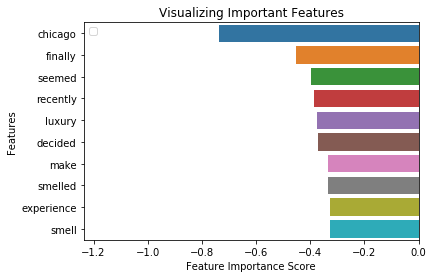

No handles with labels found to put in legend.


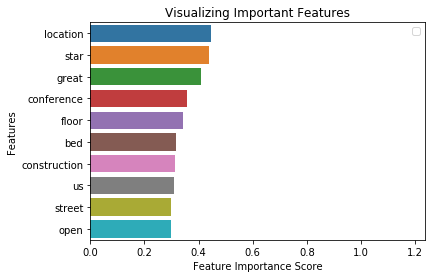

In [11]:
def best_feat(k,bigram = False, vec_type = "tfidf", min_df = False):
    train = pd.read_csv("./train.csv")
    test = pd.read_csv("test.csv")
    

    if vec_type == "tfidf":
        train_x, train_y, test_x, test_y = make_xy_train_test(train, test, bigram, min_df =  min_df)
    elif vec_type == "countvec":
        train_x, train_y, test_x, test_y = make_countvec_xy_train_test(train, test, bigram,min_df =  min_df)
    elif vec_type == "binary":
        train_x, train_y, test_x, test_y = make_countvec_xy_train_test(train, test, bigram, binary=True,min_df =  min_df)
       
    feature_names = train_x.columns

    #Extracting k best features by a a chi-squared test

    print("Extracting %d best features by a chi-squared test" %k)
    ch2 = SelectKBest(chi2, k=k)
    ch2.fit(train_x, train_y)
    feature_names_chi2 = [feature_names[i] for i in ch2.get_support(indices=True)]
    feature_score_chi2 = [ch2.scores_[i] for i in ch2.get_support(indices=True)]
    
    i=0
    for col in feature_names_chi2: 
        print('Feature: %s, Score: %.5f' %(col, feature_score_chi2[i]))
        i+=1
              
    #Extracting k best features by a mutual information

    print("Extracting %d best features by mutual information" %k)
    mut = SelectKBest(mutual_info_classif, k=k)
    mut.fit(train_x, train_y)
    feature_names_mut = [feature_names[i] for i in mut.get_support(indices=True)]
    feature_score_mut = [mut.scores_[i] for i in mut.get_support(indices=True)]
    
    i=0
    for col in feature_names_mut: 
        print('Feature: %s, Score: %.5f' %(col, feature_score_mut[i]))
        i+=1

      
    #Extracting k best features by logistic regression coefficients:
    
    # define the model
    model = linear_model.LogisticRegressionCV(cv=4, max_iter=1000, Cs=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # fit the model
    model.fit(train_x, train_y)
    # get importance
    importance = model.coef_[0]
    index = np.argsort(importance)
    n=np.shape(index)[0]
    # summarize feature importance
    print("Extracting %d best features by logistic regression coefficients:" %k)
    print("%d best features pointing towards fake reviews:" %k)
    for i in range(0,9):
        print('Feature: %s, Score: %.5f' %(feature_names[index[i]], importance[index[i]]))
        
    print("%d best features pointing towards true reviews:" %k)

    for i in range(0,9):
        print('Feature: %s, Score: %.5f' %(feature_names[index[n-i-1]], importance[index[n-i-1]]))
    if importance[index[0]]<-importance[index[n-1]]:
        x_max=importance[index[0]]-0.5
    else:
        x_max=-importance[index[n-1]]-0.5
    %matplotlib inline
    
    # Creating a bar plot for fake feat
    sns.barplot(x=importance[index[0:10]], y=feature_names[index[0:10]])
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([x_max,0])

    plt.show()
    
    # Creating a bar plot for truthful feat
    sns.barplot(x=importance[index[n-10:n]][::-1], y=feature_names[index[n-10:n]][::-1])
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([0,-x_max])
    
    plt.show()
   
    
best_feat(20,bigram = False, vec_type = "countvec", min_df = 0.01 )